BOrrowed this from: https://github.com/kazawai/shor_qiskit


In [16]:
"""
RSA and Shor's algorithm.
Based on past Qiskit implementation : https://github.com/ttlion/ShorAlgQiskit/blob/master/Shor_Normal_QFT.py
"""

import fractions
import traceback
# Time the execution of the algorithm
from time import time

from numpy import ceil, floor, gcd, log2, pi, zeros
from numpy.random import randint
# For shor's algorithm in qiskit version 1.0.1
from qiskit import (ClassicalRegister, QuantumCircuit, QuantumRegister,
                    transpile)
from qiskit.circuit.quantumcircuit import Qubit, QubitSpecifier
from qiskit_aer import AerSimulator

#####################
#   RSA algorithm   #
#####################


def rsa(P, Q):
    """Very simple RSA key generation function."""
    N = P * Q
    phi = (P - 1) * (Q - 1)
    E = 3
    while gcd(E, phi) != 1:
        E += 2
    D = 0
    while D * E % phi != 1:
        D += 1
    return (E, N), (D, N)


# Define message
message = "HELLO"
# Generate the public and private keys
# public_key, private_key = rsa(19391, 11939)
public_key, private_key = rsa(17, 11)


def rsa_encrypt(message, public_key):
    """Very simple RSA encryption function."""
    E, N = public_key
    return [pow(ord(char), E, N) for char in message]


def rsa_decrypt(message, private_key):
    """Very simple RSA decryption function."""
    D, N = private_key
    return "".join([chr(pow(char, D, N)) for char in message])


# Print the encrypted message
ciphertext = rsa_encrypt(message, public_key)
print(f"Encrypted text : {[hex(c) for c in ciphertext]}")

# Print the decrypted message
decrypted = rsa_decrypt(ciphertext, private_key)
print(f"Decrypted text : {decrypted}")

print("-" * 50)

# Set the seed for reproducible results
# seed(1)

N = public_key[1]

print("La cle publique est", public_key)
print("-" * 50)

####################
# Shor's algorithm #
####################


def qft(
    circuit: QuantumCircuit, qreg: QuantumRegister, n: int, with_swaps: bool = True
):
    """n-qubit QFT on q in circ."""
    for j in range(n - 1, 0, -1):
        circuit.h(qreg[j])
        for k in range(j - 1, -1, -1):
            if (pi / float(2 ** (j - k))) > 0:
                circuit.cp(pi / float(2 ** (j - k)), qreg[j], qreg[k])
        if with_swaps:
            circuit.barrier()

    if with_swaps:
        for j in range(n // 2):
            circuit.swap(qreg[j], qreg[n - j - 1])
    return circuit


def qft_dagger(
    circuit: QuantumCircuit, qreg: QuantumRegister, n: int, with_swaps: bool = True
):
    """n-qubit QFTdagger on q in circ."""
    if with_swaps:
        for j in range(n // 2):
            circuit.swap(qreg[j], qreg[n - j - 1])

    for j in range(n):
        circuit.h(qreg[j])
        if j != n - 1:
            for k in range(j, -1, -1):
                if (pi / float(2 ** ((j + 1) - k))) > 0:
                    circuit.cp(-pi / float(2 ** ((j + 1) - k)), qreg[j + 1], qreg[k])
        if with_swaps:
            circuit.barrier()
    return circuit


def get_angles(a, N):
    """Compute the angles for the QPE"""
    s = bin(int(a))[2:].zfill(N)
    angles = zeros([N])
    for i in range(0, N):
        for j in range(i, N):
            if s[j] == "1":
                angles[N - i - 1] += pow(2, -(j - i))
        angles[N - i - 1] *= pi
    return angles


def cc_phase_gate(
    circuit: QuantumCircuit,
    control_qubits: list[QubitSpecifier | Qubit | QuantumRegister],
    target_qubit: int,
    angle: float,
):
    """Create a doubly controlled phase gate"""
    if len(control_qubits) != 2:
        raise ValueError(
            "The doubly controlled phase gate needs exactly 2 control qubits"
        )

    circuit.cp(angle / 2, control_qubits[0], target_qubit)
    circuit.cx(control_qubits[1], control_qubits[0])
    circuit.cp(-angle / 2, control_qubits[0], target_qubit)
    circuit.cx(control_qubits[1], control_qubits[0])
    circuit.cp(angle / 2, control_qubits[1], target_qubit)


def phi_adder(
    circuit: QuantumCircuit,
    qreg: QuantumRegister,
    a: int,
    N: int,
    inverse: bool = False,
):
    """Create the circuit that performs the addition by a in the Fourier space (mod N)"""
    angles = get_angles(a, N)
    for i in range(N):
        if len(angles) == 0:
            break
        if not inverse:
            circuit.p(angles[i], qreg[i])
        else:
            circuit.p(-angles[i], qreg[i])


def controlled_phi_adder(
    circuit: QuantumCircuit,
    qreg: QuantumRegister,
    a: int,
    N: int,
    control_qubits: QuantumRegister | Qubit | list[Qubit],
    inverse: bool = False,
):
    """Controlled version of the phi_adder"""
    angles = get_angles(a, N)
    for i in range(N):
        if len(angles) == 0:
            break
        if not inverse:
            if (
                isinstance(control_qubits, QuantumRegister)
                or isinstance(control_qubits, Qubit)
                or len(control_qubits) == 1
            ):
                circuit.cp(
                    angles[i],
                    (
                        control_qubits
                        if isinstance(control_qubits, QuantumRegister)
                        or isinstance(control_qubits, Qubit)
                        else control_qubits[0]
                    ),
                    qreg[i],
                )

            else:
                cc_phase_gate(circuit, control_qubits, qreg[i], angles[i])
        else:
            if (
                isinstance(control_qubits, QuantumRegister)
                or isinstance(control_qubits, Qubit)
                or len(control_qubits) == 1
            ):
                circuit.cp(
                    -angles[i],
                    (
                        control_qubits
                        if isinstance(control_qubits, QuantumRegister)
                        or isinstance(control_qubits, Qubit)
                        else control_qubits[0]
                    ),
                    qreg[i],
                )
            else:
                cc_phase_gate(circuit, control_qubits, qreg[i], -angles[i])


def controlled_phi_adder_mod_N(
    circuit: QuantumCircuit,
    qreg: QuantumRegister,
    a: int,
    N: int,
    n: int,
    control_qubits: QuantumRegister | Qubit | list[Qubit],
    ancilla_qubit: Qubit,
):
    """Controlled version of the phi_adder"""
    controlled_phi_adder(circuit, qreg, a, n, control_qubits, False)
    phi_adder(circuit, qreg, N, n, True)
    qft_dagger(circuit, qreg, n, False)
    circuit.cx(qreg[n - 1], ancilla_qubit)
    qft(circuit, qreg, n, False)
    controlled_phi_adder(circuit, qreg, N, n, control_qubits, False)

    controlled_phi_adder(circuit, qreg, a, n, control_qubits, True)
    qft_dagger(circuit, qreg, n, False)
    circuit.x(qreg[n - 1])
    circuit.cx(qreg[n - 1], ancilla_qubit)
    circuit.x(qreg[n - 1])
    qft(circuit, qreg, n, False)
    controlled_phi_adder(circuit, qreg, a, n, control_qubits, False)


def controlled_phi_adder_mod_N_inv(
    circuit: QuantumCircuit,
    qreg: QuantumRegister,
    a: int,
    N: int,
    n: int,
    control_qubits: QuantumRegister | Qubit | list[Qubit],
    ancilla_qubit: Qubit,
):
    """Controlled version of the inverse phi_adder"""
    controlled_phi_adder(circuit, qreg, a, n, control_qubits, True)
    qft_dagger(circuit, qreg, n, False)
    circuit.x(qreg[n - 1])
    circuit.cx(qreg[n - 1], ancilla_qubit)
    circuit.x(qreg[n - 1])
    qft(circuit, qreg, n, False)
    controlled_phi_adder(circuit, qreg, a, n, control_qubits, False)

    controlled_phi_adder(circuit, qreg, N, n, control_qubits, False)
    qft_dagger(circuit, qreg, n, False)
    circuit.cx(qreg[n - 1], ancilla_qubit)
    qft(circuit, qreg, n, False)
    phi_adder(circuit, qreg, N, n, False)
    controlled_phi_adder(circuit, qreg, a, n, control_qubits, True)


def controlled_mult_mod_N(
    circuit: QuantumCircuit,
    qreg: QuantumRegister,
    a: int,
    N: int,
    n: int,
    control_reg: QuantumRegister | Qubit,
    ancilla_reg: QuantumRegister,
):
    """Controlled version of the multiplication by a mod N"""
    qft(circuit, ancilla_reg, n + 1, False)
    for i in range(n):
        controlled_phi_adder_mod_N(
            circuit,
            ancilla_reg,
            (2**i) * a % N,
            N,
            n + 1,
            [qreg[i], control_reg],
            ancilla_reg[n + 1],
        )
    qft_dagger(circuit, ancilla_reg, n + 1, False)

    for i in range(n):
        circuit.cswap(control_reg, qreg[i], ancilla_reg[i])

    a_inv = pow(a, -1, N)
    qft(circuit, ancilla_reg, n + 1, False)

    for i in range(n):
        controlled_phi_adder_mod_N_inv(
            circuit,
            ancilla_reg,
            pow(2, i) * a_inv % N,
            N,
            n + 1,
            [qreg[i], control_reg],
            ancilla_reg[n + 1],
        )
    qft_dagger(circuit, ancilla_reg, n + 1, False)


def find_factors_prime_power(N):
    """Check if N is a perfect power and return the factors"""
    for k in range(2, int(floor(log2(N))) + 1):
        c = pow(N, 1 / k)
        c1 = floor(c)
        if c1**k == N:
            return c1
        c2 = ceil(c)
        if c2**k == N:
            return c2
    return None


def qpe_period_finding(N, a, n) -> int | str:
    """Quantum Phase Estimation for period finding"""
    q_up = QuantumRegister(2 * n, "q_up")
    q_down = QuantumRegister(n, "q_down")
    a_q = QuantumRegister(n + 2, "a_q")
    c = ClassicalRegister(2 * n, "c")
    qpe = QuantumCircuit(q_up, q_down, a_q, c)
    try:
        # Initialize qubits
        qpe.h(q_up)
        qpe.x(q_down[0])

        # Apply controlled multiplication gates
        for i in range(n):
            controlled_mult_mod_N(
                qpe, q_down, int(pow(a, pow(2, i))), N, n, q_up[i], a_q
            )

        # Apply inverse QFT
        qft_dagger(qpe, q_up, 2 * n, True)

        # Measure the qubits
        qpe.measure(q_up, c)

        # Transpile the circuit
        try:
            transpiled_qpe = transpile(qpe, AerSimulator())
        except Exception as e:
            print(traceback.format_exc())
            return "Error"

        # Simulate the QuantumCircuit
        result = AerSimulator().run(transpiled_qpe, shots=1024, memory=True).result()
        mem = result.get_memory()

        # Extract the phase
        phase = int(mem[0], 2) / (2 ** (2 * n))

        # Find the period
        r = fractions.Fraction(phase).limit_denominator(N - 1).denominator

        return r

    except Exception as e:
        print(traceback.format_exc())
        # print(qpe.draw())
        return "Error"


def shor(N):
    """Shor's algorithm"""
    # Check if N is a perfect power
    r = find_factors_prime_power(N)
    if r is not None:
        return r, N // r

    # Get a random coprime of N
    a = randint(2, N)
    if gcd(a, N) != 1:
        print(f"Lucky guess: {gcd(a, N)} is a factor of {N}")
        return (gcd(a, N), N // gcd(a, N))
    print(f"The coprime of {N} is {a}")

    # Find the period
    n = int(ceil(log2(N)))

    # Thanks Qiskit for the following code (source : https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb)
    FACTOR_FOUND = False
    ATTEMPT = 0
    while not FACTOR_FOUND:
        ATTEMPT += 1
        print(f"\nATTEMPT {ATTEMPT}:")
        # Update a for each attempt
        a = randint(2, N)
        if gcd(a, N) != 1:
            print(f"Lucky guess: {gcd(a, N)} is a factor of {N}")
            return (gcd(a, N), N // gcd(a, N))

        r = qpe_period_finding(N, a, n)
        if r == "Error":
            print("Error")
            return 0, 0
        print(f"Result: r = {r}")
        if r != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a ** (r // 2) - 1, N), gcd(a ** (r // 2) + 1, N)]
            print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
            for guess in guesses:
                if guess not in [1, N] and (N % guess) == 0:
                    # Guess is a factor!
                    print(f"*** Non-trivial factor found: {guess} ***")
                    FACTOR_FOUND = True
                    return guess, N // guess


if __name__ == "__main__":
    # Time the execution of the algorithm
    print("Algorithme quantique de Shor")
    N = 15
    start = time()
    factors = shor(N)
    end = time()
    print(
        f"Les facteurs premiers de {N} sont {factors} : trouve en {end - start} secondes"
    )
    print("-" * 50)
    

Encrypted text : ['0xb7', '0x89', '0x57', '0x57', '0x6b']
Decrypted text : HELLO
--------------------------------------------------
La cle publique est (3, 187)
--------------------------------------------------
Algorithme quantique de Shor
The coprime of 15 is 2

ATTEMPT 1:
Result: r = 13
Guessed Factors: 15 and 1

ATTEMPT 2:
Result: r = 9
Guessed Factors: 15 and 1

ATTEMPT 3:
Result: r = 1
Guessed Factors: 15 and 1

ATTEMPT 4:
Lucky guess: 3 is a factor of 15
Les facteurs premiers de 15 sont (np.int64(3), np.int64(5)) : trouve en 7.539894104003906 secondes
--------------------------------------------------


Copilot generated

In [4]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from math import gcd
from numpy.random import randint
from fractions import Fraction

def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # Initialize state |1> for the 4th qubit
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                  [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    return qc

def c_amod15(a, power):
    U = QuantumCircuit(4)        
    for iteration in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


Run Shor's Algorithm

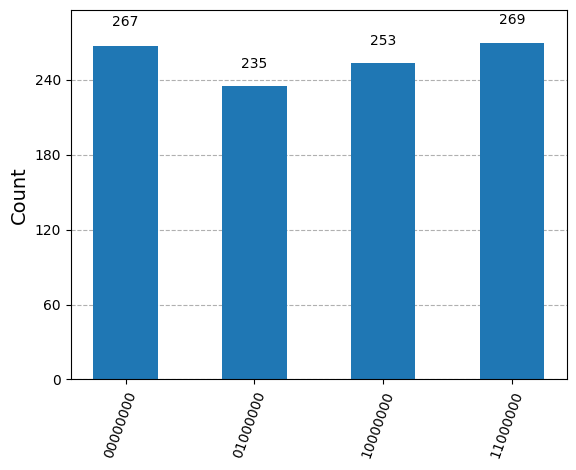

In [7]:
N = 15
a = 7
qc = qpe_amod15(a)
# backend = Aer.get_backend('qasm_simulator')
sim = AerSimulator()
transpiled_qc = transpile(qc, sim)
job = sim.run(transpiled_qc)
hist = job.result().get_counts()
plot_histogram(hist)
